## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from keras.utils import timeseries_dataset_from_array
import os

## Data pre-processing

In [3]:
def func(timePath, responsePath, timeStamps):
    time_df = pd.read_csv(timePath)
    time_df['attentive'] = 1
    old = 0
    resp_df = pd.read_csv(responsePath)
    for index, row in resp_df.iterrows():
        if(row[' Correct'] == ' Yes'):
            old = row['Elapsed Time (ms)']
            continue
        new = row['Elapsed Time (ms)']
        time_df.loc[(time_df['Elapsed Time (ms)'] >= old) & (time_df['Elapsed Time (ms)'] <= new), 'attentive'] = 0
    
    # Update time_df and remove old ' Pitch' and ' Roll' columns
    time_df[' Pitch'] = round(((time_df[' Pitch'] + 180) % 360), 2)
    time_df[' Roll'] = round(((time_df[' Roll'] + 180) % 360), 2)
    time_df[' Yaw'] = round(((time_df[' Yaw'] + 180) % 360), 2)
    
    time_df = time_df.drop(['Elapsed Time (ms)', ' Alphabet'], axis=1)
    dataset = timeseries_dataset_from_array(np.asarray(time_df)[: -timeStamps], np.asarray(time_df['attentive'])[timeStamps:], 10, batch_size=71000)
    for index, batch in enumerate(dataset):
        features, labels = batch
        
       
    return features, labels
    
    
features_arr, labels_arr = func('../data/timeFile_1.csv', '../data/responseFile_1.csv', 10)


In [4]:
# List of response and time file paths
response_files = ['responseFile_1.csv', 'responseFile_3.csv', 'responseFile_4.csv', 'responseFile_5.csv', 'responseFile_6.csv', 'responseFile_7.csv']
time_files = ['timeFile_1.csv', 'timeFile_3.csv', 'timeFile_4.csv', 'timeFile_5.csv', 'timeFile_6.csv', 'timeFile_7.csv']

# Process each file and stack the datasets
stacked_features, stacked_labels = None, None
for time_file, response_file in zip(time_files, response_files):
    dataset = func('../data/' + time_file, '../data/' + response_file, 10)
    if stacked_features is None:
        stacked_features, stacked_labels = dataset
    else:
        stacked_features = np.concatenate([stacked_features, dataset[0]], axis=0)
        stacked_labels = np.concatenate([stacked_labels, dataset[1]], axis=0)

# Print the shapes of the stacked datasets
print("Stacked Features Shape:", stacked_features.shape)
print("Stacked Labels Shape:", stacked_labels.shape)

Stacked Features Shape: (120312, 10, 4)
Stacked Labels Shape: (120312,)


In [14]:
input_layer = tf.keras.layers.Input(shape=(10, stacked_features.shape[2]))

# LSTM layer
lstm_layer = tf.keras.layers.LSTM(32, activation='tanh', recurrent_dropout=0.2, dropout=0.2)(input_layer)

# Output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_layer)

# Create the model
non_sequential_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
non_sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)


train_features = stacked_features[:100000, :, :]
train_labels = stacked_labels[:100000]
test_features = stacked_features[100000:, :, :]
test_labels = stacked_labels[100000:]


base_history = non_sequential_model.fit(train_features, train_labels, batch_size = 32, epochs = 3, verbose = 1, validation_data=(test_features, test_labels))

Epoch 1/3
3125/3125 [==============================] - 23s 7ms/step - loss: 0.3343 - accuracy: 0.8934 - val_loss: 0.2554 - val_accuracy: 0.9155
Epoch 2/3
3125/3125 [==============================] - 22s 7ms/step - loss: 0.1576 - accuracy: 0.9441 - val_loss: 0.0411 - val_accuracy: 0.9902
Epoch 3/3
3125/3125 [==============================] - 22s 7ms/step - loss: 0.0506 - accuracy: 0.9881 - val_loss: 0.0265 - val_accuracy: 0.9954


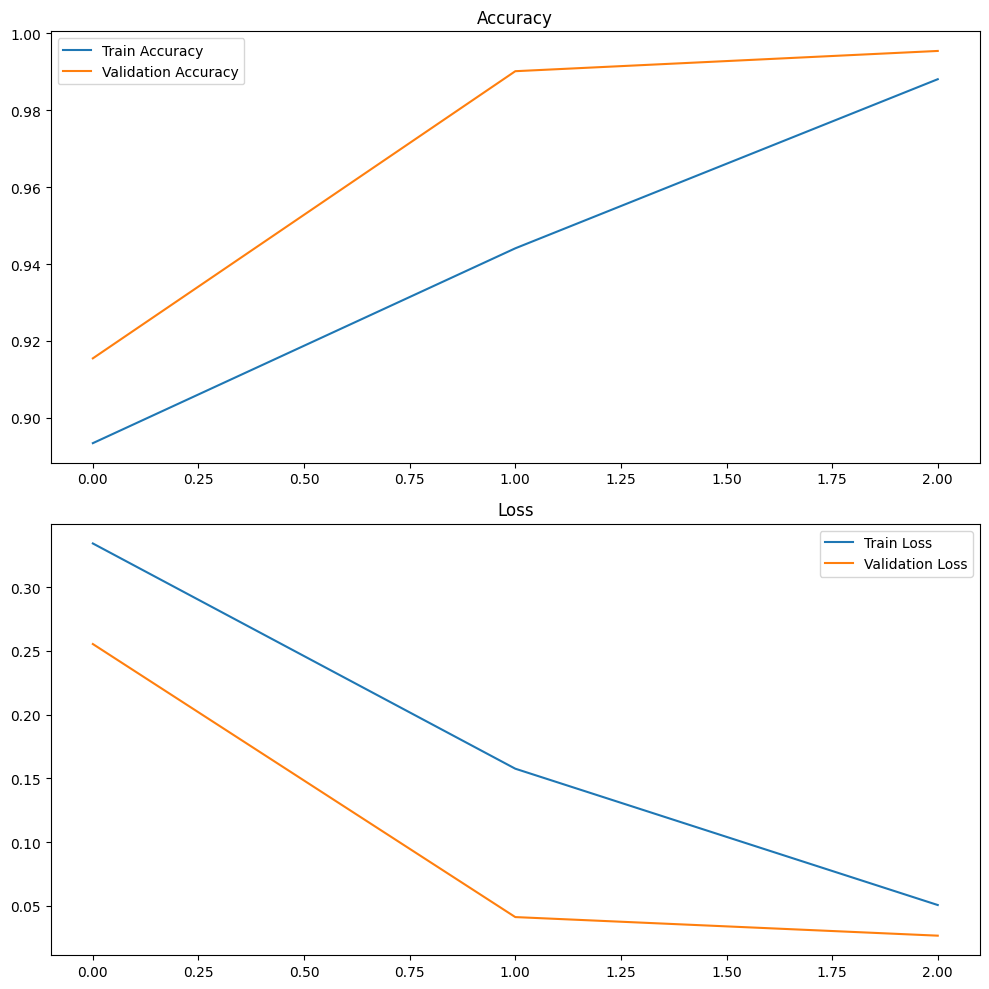

In [16]:
# Plot accuracy and loss
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].plot(base_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(base_history.history['val_accuracy'], label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(base_history.history['loss'], label='Train Loss')
ax[1].plot(base_history.history['val_loss'], label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

plt.tight_layout()
plt.show()